In [4]:
import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
from textrank4zh import TextRank4Keyword

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import re
import string
import nltk

from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

In [5]:
#Read CSV
df=pd.read_csv("21tweet_data.csv",index_col ="target")
#print(df.count())

#Remove Not Disaster Tweet
df = df.drop(0, axis=0)
df.count()

id                 31
conversation_id    31
created_at         31
date               31
time               31
timezone           31
user_id            31
username           31
name               31
place               0
text               31
language           31
mentions           31
urls               31
photos             31
replies_count      31
retweets_count     31
likes_count        31
hashtags           31
cashtags           31
link               31
retweet            31
quote_url           5
video              31
thumbnail           7
near                0
geo                 0
source              0
user_rt_id          0
user_rt             0
retweet_id          0
reply_to           31
retweet_date        0
translate           0
trans_src           0
trans_dest          0
dtype: int64

## Text Preprocessing


In [6]:
def clean_text(text):
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


df['text'] = df['text'].apply(lambda x: clean_text(x))

In [7]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
df['text'] = df['text'].apply(lambda x: tokenizer.tokenize(x))


In [8]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def combine_text(text):
    all_text = ' '.join(text)
    return all_text

In [13]:
df['text'] = df['text'].apply(lambda x: combine_text(x))

In [14]:
def stem_lem(text):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemm_text =  " ".join(lemmatizer.lemmatize(token) for token in tokens)
    return lemm_text

In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
df['text'] = df['text'].apply(lambda x: stem_lem(x))

## Location Extraction

In [17]:
#Location Extraction Using SpaCy

nlp = en_core_web_sm.load()
def location(df_text):
    text = df_text
    doc = nlp(text)
    location = []
    for entity in doc.ents:
        if entity.label_ == "LOC" or entity.label_ == "GPE":
            location.append(entity.text) 
    return location

In [18]:
df['location'] = df['text'].apply(lambda x: location(x))

In [19]:
#convert location column to a list
location_list = df['location'].to_numpy()
#print(location_list)

#remove none and null value
location_list = list(filter(None, location_list))
#print(location_list)

In [20]:
#Convert all list location to a list for better calculation
list_location = []
for x in range(len(location_list)):
    list_location.extend(location_list[x])

In [21]:
#Built a temp location dataframe
temp_location_df = pd.DataFrame(columns=['location'])
temp_location_df['location'] = list_location

#check output
print(temp_location_df['location'])

0    capital hill
1      washington
2     nashville u
3       tennessee
4    capital hill
5          thomas
Name: location, dtype: object


In [22]:
#Location Count 
feat = temp_location_df['location'].value_counts()
print(feat.head(20))

capital hill    2
washington      1
tennessee       1
nashville u     1
thomas          1
Name: location, dtype: int64


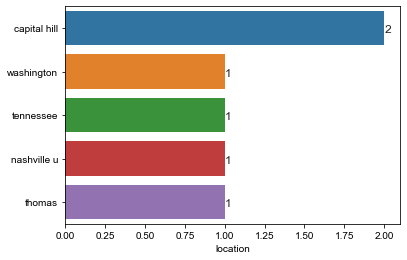

In [23]:
#Draw Bar Plot
ax = sns.barplot(y=temp_location_df['location'].value_counts()[:15].index,x=temp_location_df['location'].value_counts()[:15],orient='h')

sns.set(rc={'figure.figsize':(11.7,8.27)})
initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:1.0f}'.format(p.get_width()))
  initialx+=1

## Keyword Extraction

In [24]:
def keyword(df_text):
    text = df_text
    tr4w = TextRank4Keyword()
    keyword = []
    tr4w.analyze(text=text, lower=True, window=2)
    for item in tr4w.get_keywords(4, word_min_len=5):
        keyword.append(item.word)
    return keyword

In [25]:
df['keyword'] = df['text'].apply(lambda x: keyword(x))

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\User\AppData\Local\Temp\jieba.cache
Loading model cost 5.827 seconds.
Prefix dict has been built successfully.


In [26]:
#convert keyword column to a list
keyword_list = df['keyword'].to_numpy()
#print(keyword_list)

#remove none and null value
keyword_list = list(filter(None, keyword_list))
#print(keyword_list)

In [27]:
#Convert all list location to a list for better calculation
list_keyword = []
for x in range(len(keyword_list)):
    list_keyword.extend(keyword_list[x])

In [28]:
temp_keyword_df = pd.DataFrame(columns=['keyword'])
temp_keyword_df['keyword'] = list_keyword

In [29]:
feat =temp_keyword_df['keyword'].value_counts()
print(feat.head(5))

capital      12
police        5
terrorist     3
trump         3
protest       3
Name: keyword, dtype: int64


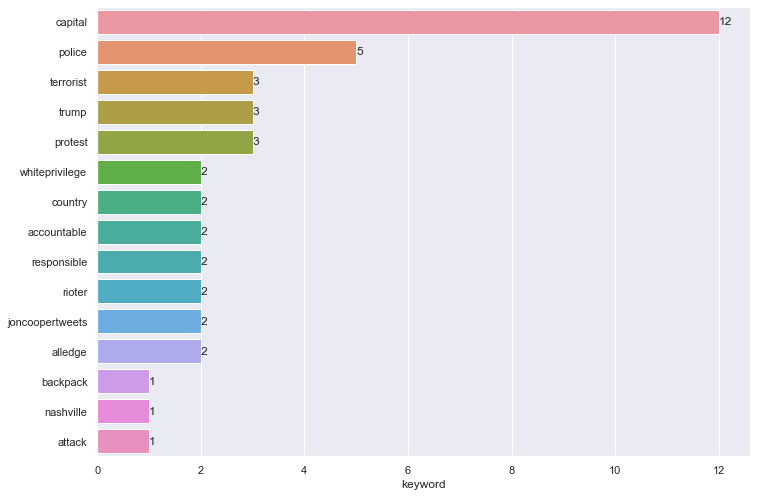

In [30]:
import matplotlib.pyplot as plt
ax = sns.barplot(y=temp_keyword_df['keyword'].value_counts()[:15].index,x=temp_keyword_df['keyword'].value_counts()[:15],orient='h')

sns.set(rc={'figure.figsize':(11.7,8.27)})
initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:1.0f}'.format(p.get_width()))
  initialx+=1


In [31]:
initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:1.0f}'.format(p.get_width()))
  initialx+=1

In [32]:
initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:1.0f}'.format(p.get_width()))
  initialx+=1

In [33]:
initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:1.0f}'.format(p.get_width()))
  initialx+=1

In [34]:
from google.colab import files

df.to_csv('df.csv')
files.download('df.csv')

ModuleNotFoundError: No module named 'google'

## API Built

In [ ]:

files.download('df.json')

In [ ]:
df_api = temp_location_df['location'].value_counts(normalize=True)

In [ ]:
print(df_api)

In [ ]:
df_api.to_csv('df1.csv')

In [ ]:
files.download('df1.csv')

In [ ]:
pip install spacy

In [ ]:
python -m spacy download en_core_web_sm